# Training Notebook

## Importing libraries

In [3]:
%load_ext tensorboard
#
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.core import Dense, Flatten
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
#from tensorflow.keras.layers.convolutional import *
from tensorflow.keras.layers import *
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation, Dense, Flatten, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

import tensorflow as tf

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import shutil

print(tf.__version__)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.4.1


In [4]:

def createFolder(folderPath):
    if not os.path.exists(folderPath):
        os.mkdir(folderPath)

def copyFileList(sourceFolderPath, targetFolderPath, fileList):    
    # Copy actual images in the new folder
    for imgName in fileList:
        src_file = os.path.join(sourceFolderPath, imgName)
        dst_file = os.path.join(targetFolderPath, imgName)
        shutil.copy2(src_file, dst_file)

class DataAugmentation():
    def flipImage(self, image, orientation=-1):
        nonflip = -1
        vertical = 0
        horizontal = 1
        if   orientation == nonflip:    return image
        elif orientation == vertical:   return cv2.flip(image, vertical)
        elif orientation == horizontal: return cv2.flip(image, horizontal)

    def rotateImage(self, image, angle=0):
        # angle in degrees
        h, w = image.shape[:2]
        cX, cY = w // 2, h // 2
        # rotate our image by "angle" degrees around the center of the image
        M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
        return cv2.warpAffine(image, M, (w, h))

    def getNumberOfNewSamplePerClass(self, dataset_path):
        classNames = os.listdir(dataset_path)
        N = []
        max_n = 0
        for folder in classNames:
            path = os.path.join(dataset_path, folder)
            n = len(os.listdir(path))
            if n > max_n: max_n = n
            N.append(n)
        idx = np.argsort(np.array(N))
        classNames = np.array(classNames)[idx]
        exampleNumberPerClass = np.array(N)[idx]
        exampleNumberNeededPerClass = max_n - exampleNumberPerClass
        return classNames, exampleNumberNeededPerClass, exampleNumberPerClass

    def augmentationOfOneClass(self, datasetInFolderPath, datasetOutFolderPath, className, quantity):
        """
        datasetInFolderPathPath: input datase dataset's path with the actual images
        datasetOutFolderPathPath: output datase dataset's path to save actual and new images
        className: name of the class
        quantity: number of new images to be generated. This number MUST be less or equal than
                the number of images, for the class "className", times 23 (<= 23 * N)
        """
        # imageFolderList: List of names of the file for the class "className"
        imageFolderList = os.listdir(os.path.join( datasetInFolderPath, className))
            
        createFolder(datasetOutFolderPath)
        outpathClass = os.path.join(datasetOutFolderPath, className)
        createFolder(outpathClass)
            
        # Copy actual images in the new folder
        inpathClass = os.path.join(datasetInFolderPath, className)
        copyFileList(inpathClass, outpathClass, imageFolderList)
        
        if quantity > 0:
            rotationAngles = [0, 45, 90, 135, 180, 225, 270, 315]
            nonflip = -1
            vertical = 0
            horizontal = 1
            # sufix[nonflip] = "", sufix[vertical] = "v", sufix[horizontal] = "h",
            sufix = ["_v", "_h", ""] # 
            flippings = [nonflip, vertical, horizontal]
            r, f = np.meshgrid(rotationAngles, flippings)
            # Excluding non-rotated and no-flipped image
            transfs = np.array([r.flatten(), f.flatten()]).T[1:,:]
            # Number of transformations
            Nt = transfs.shape[0]
            # Number of images
            Ni = len(imageFolderList)
            ni, nt = np.meshgrid(np.arange(0,Ni-1), np.arange(0,Nt-1))
            combinations = np.array([ni.flatten(), nt.flatten()]).T
            nComb = combinations.shape[0]
            choice = np.random.permutation(nComb)[:quantity]
            for sel in choice:
                comb = combinations[sel]
                imgName = imageFolderList[comb[0]]
                extension = imgName[imgName.rfind("."):]
                extLen = len(extension)
                transf = transfs[comb[1]]
                angle, flip = transf[0], transf[1]
                filename = os.path.join(datasetInFolderPath, className, imgName)
                image = cv2.imread(filename)
                image = self.rotateImage(image, angle=angle)
                image = self.flipImage(image, orientation=flip)
                imgName = imgName[:-extLen] + f"-{angle}" + sufix[transf[1]] + extension 
                filename = os.path.join(datasetOutFolderPath, className, imgName)
                cv2.imwrite(filename, image)
        return None


def splitDatasetTrnValTst(datasetInPath, trainDirectory, train_split=0.7, val_split=0.2, test_split=0.1, random_seed=123):

    folderTrainPath = os.path.join(trainDirectory, "train")
    folderValPath = os.path.join(trainDirectory, "val")
    folderTestPath = os.path.join(trainDirectory, "test")

    np.random.seed(random_seed)

    for className in os.listdir(datasetInPath):
        classFolder = os.path.join(datasetInPath, className)
        fileList = np.array(os.listdir(classFolder))
        class_N = len(fileList)
        train_N = int(np.ceil(class_N * train_split))
        val_N = int(np.ceil(class_N * val_split))
        test_N = class_N - train_N - val_N

        shuffle = np.random.permutation(class_N)
        fileList = fileList[shuffle]

        trainFileList = fileList[:train_N]
        valFileList = fileList[train_N:train_N + val_N]
        testFileList = fileList[train_N + val_N:]

        createFolder(folderTrainPath)
        createFolder(folderValPath)
        createFolder(folderTestPath)

        folderTrainClassPath = os.path.join(folderTrainPath, className)
        folderValClassPath = os.path.join(folderValPath, className)
        folderTestClassPath = os.path.join(folderTestPath, className)

        createFolder(folderTrainClassPath)
        createFolder(folderValClassPath)
        createFolder(folderTestClassPath)

        copyFileList(classFolder, folderTrainClassPath, trainFileList)
        copyFileList(classFolder, folderValClassPath, valFileList)
        copyFileList(classFolder, folderTestClassPath, testFileList)

def splitDataset(datasetInPath, trainDirectory, train_split=0.7, val_split=0.3, random_seed=123):

    folderTrainPath = os.path.join(trainDirectory, "train")
    folderValPath = os.path.join(trainDirectory, "val")

    np.random.seed(random_seed)

    for className in os.listdir(datasetInPath):
        classFolder = os.path.join(datasetInPath, className)
        fileList = np.array(os.listdir(classFolder))
        class_N = len(fileList)
        train_N = int(np.ceil(class_N * train_split))
        val_N = int(np.ceil(class_N * val_split))

        shuffle = np.random.permutation(class_N)
        fileList = fileList[shuffle]

        trainFileList = fileList[:train_N]
        valFileList = fileList[train_N:]

        createFolder(folderTrainPath)
        createFolder(folderValPath)

        folderTrainClassPath = os.path.join(folderTrainPath, className)
        folderValClassPath = os.path.join(folderValPath, className)

        createFolder(folderTrainClassPath)
        createFolder(folderValClassPath)

        copyFileList(classFolder, folderTrainClassPath, trainFileList)
        copyFileList(classFolder, folderValClassPath, valFileList)


## Defining the train images path and partial test images path in which we have to add the image to convert it into full path.

In [5]:
train_path = "/home/guest/Polen/FineTuningPollen/Honey.AI_PracticalTest_Dataset"
import os
print(os.listdir(train_path))

['Tilia', 'Helianthus annuus', 'Eucalyptus sp', 'Erica.m', 'Cardus', 'Rosmarinus officinalis', 'Lavandula', 'Citrus sp', 'Brassica', 'Pinus', 'Cistus sp', 'Taraxacum']


In [6]:
dataset_in_path = "/home/guest/Polen/FineTuningPollen/Honey.AI_PracticalTest_Dataset"
dataset_out_path = "/home/guest/Polen/FineTuningPollen/Honey-Augmented"

dataset = DataAugmentation()
classNames, exampleNumberNeededPerClass, exampleNumberPerClass = dataset.getNumberOfNewSamplePerClass(dataset_in_path)

for className, exampleNumberNeededOneClass in zip(classNames, exampleNumberNeededPerClass):
    print(className, exampleNumberNeededOneClass)
    # ********** uncoment for data augmentation ***********
    #dataset.augmentationOfOneClass(dataset_in_path, dataset_out_path, className, exampleNumberNeededOneClass)


Cardus 1654
Taraxacum 1592
Pinus 1561
Rosmarinus officinalis 1324
Citrus sp 1319
Tilia 1171
Cistus sp 1154
Lavandula 1099
Helianthus annuus 931
Eucalyptus sp 899
Brassica 442
Erica.m 0


In [7]:
datasetSplitPath = "/home/guest/Polen/FineTuningPollen"
    
# ******* uncoment for dataset folder generation (train, val, test) ********
#splitDatasetTrnValTst(dataset_out_path, datasetSplitPath)

trainPath = os.path.join(datasetSplitPath, "train")
valPath = os.path.join(datasetSplitPath, "val")
testPath = os.path.join(datasetSplitPath, "test")


In [8]:
# dataset generation using keras

batch_size = 512
img_height = 224
img_width = 224
random_seed = 123

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  trainPath,
  label_mode = "categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True,
  seed = random_seed)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  valPath,
  label_mode = "categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = False,
  seed = random_seed)

class_names = train_dataset.class_names 

useThreeDatasets = True

if not useThreeDatasets:
    
    # Creating test set from the validation set
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 3)
    validation_dataset = validation_dataset.skip(val_batches // 3)

    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
else:
    # NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
    # Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

    # batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once,
    # i.e., no data is left out
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        testPath,
        label_mode = "categorical",
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle = False,
        seed = random_seed)
    

Found 15492 files belonging to 12 classes.
Found 4428 files belonging to 12 classes.
Found 2196 files belonging to 12 classes.


In [9]:
# Setting of the datasets for improving performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## Importing keras pretrained model (without top layers) as base model. Select between restnet50 and resnet101.

In [10]:
#base_model = keras.applications.resnet50.ResNet50( weights = 'imagenet',include_top = False,input_shape = (224,224,3))
base_model = keras.applications.ResNet101( weights = 'imagenet',include_top = False,input_shape = (224,224,3))
#base_model.summary()
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  345


# base model layers are frozen.

In [11]:
for layer in base_model.layers:
    layer.trainable = False

## Building keras sequential model by using base model layer as its lower layer and two fully connected dense layer.

In [12]:
#classes = train_dataset.class_names
#class_indices=list(train_gen.class_indices.values())

num_of_classes=len(class_names)

x = base_model.output
x = GlobalAveragePooling2D(name='glob_avg_pooling')(x)
#x = AveragePooling2D(name='avg_pooling')(x)
x = Flatten(name='flatten')(x)
x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01), name='fc_1')(x)
x = Activation("relu", name='relu_1')(x)
x = Dropout(0.2, name="dropout")(x)
x = Dense(128, name='fc_2')(x)
x = Activation("relu", name='relu_2')(x)
predictions = Dense(num_of_classes, activation='softmax', name='outputs')(x)
       
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000,activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))
print(model.summary())

## Compile and train the model using 50 epochs

In [46]:
metrics = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.CategoricalAccuracy(name='acc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           "mse"]

base_learning_rate = 0.0001

model.compile(optimizer=Adam(base_learning_rate),
              loss='categorical_crossentropy',
              #metrics=['acc'])
              metrics=metrics)

## Callback definitions. Please select log_dir.  

In [47]:
from tensorflow.keras.callbacks import Callback
import datetime

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss", mode='min')

#log_dir = "logs-resnet50/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs-resnet101/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb=[early_stop, tensorboard_callback] 

In [48]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=cb)

Epoch 1/50
31/31 [==============================] - 57s 2s/step - loss: 465.4296 - tp: 43.0312 - fp: 39.1250 - tn: 92451.6250 - fn: 8365.2188 - acc: 0.1961 - precision: 0.3459 - recall: 0.0037 - auc: 0.6125 - mse: 0.0761 - val_loss: 415.4249 - val_tp: 289.0000 - val_fp: 2.0000 - val_tn: 48706.0000 - val_fn: 4139.0000 - val_acc: 0.6606 - val_precision: 0.9931 - val_recall: 0.0653 - val_auc: 0.9411 - val_mse: 0.0547
Epoch 2/50
31/31 [==============================] - 49s 1s/step - loss: 400.6280 - tp: 1221.1250 - fp: 28.0000 - tn: 92462.7500 - fn: 7187.1250 - acc: 0.6722 - precision: 0.9793 - recall: 0.1256 - auc: 0.9449 - mse: 0.0509 - val_loss: 357.0891 - val_tp: 1652.0000 - val_fp: 37.0000 - val_tn: 48671.0000 - val_fn: 2776.0000 - val_acc: 0.8193 - val_precision: 0.9781 - val_recall: 0.3731 - val_auc: 0.9786 - val_mse: 0.0359
Epoch 3/50
31/31 [==============================] - 50s 1s/step - loss: 343.4920 - tp: 3408.1250 - fp: 83.9375 - tn: 92406.8125 - fn: 5000.1250 - acc: 0.8077 - 

31/31 [==============================] - 50s 1s/step - loss: 1.0839 - tp: 6859.9375 - fp: 283.9375 - tn: 92206.8125 - fn: 1548.3125 - acc: 0.9024 - precision: 0.9607 - recall: 0.8137 - auc: 0.9952 - mse: 0.0151 - val_loss: 1.0665 - val_tp: 3661.0000 - val_fp: 148.0000 - val_tn: 48560.0000 - val_fn: 767.0000 - val_acc: 0.9045 - val_precision: 0.9611 - val_recall: 0.8268 - val_auc: 0.9950 - val_mse: 0.0145
Epoch 40/50
31/31 [==============================] - 50s 1s/step - loss: 1.0712 - tp: 6904.8750 - fp: 283.0312 - tn: 92207.7188 - fn: 1503.3750 - acc: 0.9029 - precision: 0.9602 - recall: 0.8198 - auc: 0.9953 - mse: 0.0149 - val_loss: 1.1106 - val_tp: 3548.0000 - val_fp: 183.0000 - val_tn: 48525.0000 - val_fn: 880.0000 - val_acc: 0.8882 - val_precision: 0.9510 - val_recall: 0.8013 - val_auc: 0.9933 - val_mse: 0.0164
Epoch 41/50
31/31 [==============================] - 50s 1s/step - loss: 1.0749 - tp: 6894.5000 - fp: 321.5938 - tn: 92169.1562 - fn: 1513.7500 - acc: 0.9032 - precision: 0

In [24]:
%tensorboard --logdir logs-resnet50/fit

## Model evaluation

In [14]:
model.evaluate(test_dataset)

5/5 [==============================] - 31s 4s/step - loss: 0.9505 - tp: 1885.0000 - fp: 79.0000 - tn: 24077.0000 - fn: 311.0000 - acc: 0.9176 - precision: 0.9598 - recall: 0.8584 - auc: 0.9968 - mse: 0.0125


(0.9504806995391846,
 1885.0,
 79.0,
 24077.0,
 311.0,
 0.9175773859024048,
 0.959775984287262,
 0.8583788871765137,
 0.9967795014381409,
 0.01246138010174036)

## Model saving. Please select the network.

In [15]:
#modelName = "resnet50"
modelName = "resnet101"
#model.save( modelName + '.h5')

## Training performance

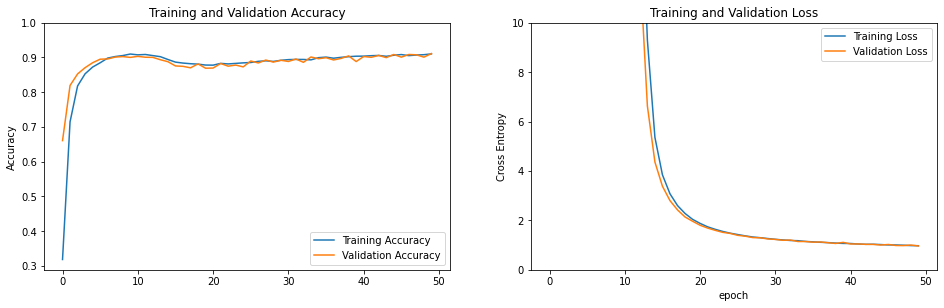

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(modelName + '.jpg', bbox_inches='tight')
plt.show()

## Snap shots

Exactitud: 0.904296875

Elapsed time: 2.00 sec.


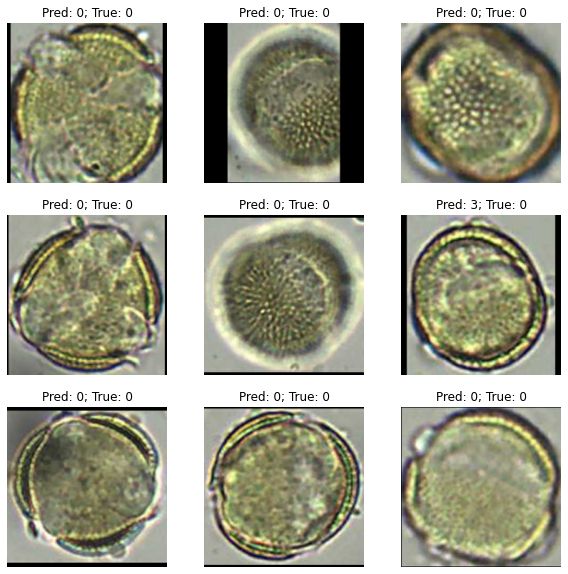

In [148]:
import time
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

start = time.time()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions, axis=1)
elapsed_time = time.time() - start
print("Exactitud:", sum(predictions==np.argmax(label_batch, axis=1)) / len(predictions))
print(f"\nElapsed time: {np.round(elapsed_time):4.2f} sec." )

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {predictions[i]}; True: {np.argmax(label_batch[i])}")
    plt.axis("off")

## Fine Tuning. Please select for each model (resnet50, resnet101)

In [16]:
print("Number of layer of the base model:", len(base_model.layers))

model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 341 # 172 for resnet50, 341 for resnet101

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False


Number of layer of the base model for RESNET101: 345


## Compiling for fine-tunning 

In [20]:
model.compile(loss="categorical_crossentropy",
              optimizer = Adam(learning_rate=base_learning_rate/10),
              metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Training for  fine-tunning.

In [21]:
history_fine = model.fit(train_dataset,
                         epochs=50,
                         validation_data=validation_dataset)

Epoch 1/50
31/31 [==============================] - 85s 2s/step - loss: 0.8414 - acc: 0.9110 - val_loss: 0.7342 - val_acc: 0.9058
Epoch 2/50
31/31 [==============================] - 50s 1s/step - loss: 0.7316 - acc: 0.9184 - val_loss: 0.7144 - val_acc: 0.9112
Epoch 3/50
31/31 [==============================] - 51s 1s/step - loss: 0.7192 - acc: 0.9177 - val_loss: 0.7074 - val_acc: 0.9149
Epoch 4/50
31/31 [==============================] - 50s 1s/step - loss: 0.7180 - acc: 0.9147 - val_loss: 0.7046 - val_acc: 0.9169
Epoch 5/50
31/31 [==============================] - 50s 1s/step - loss: 0.7068 - acc: 0.9208 - val_loss: 0.7000 - val_acc: 0.9164
Epoch 6/50
31/31 [==============================] - 51s 1s/step - loss: 0.7048 - acc: 0.9175 - val_loss: 0.6971 - val_acc: 0.9164
Epoch 7/50
31/31 [==============================] - 50s 1s/step - loss: 0.7025 - acc: 0.9179 - val_loss: 0.6938 - val_acc: 0.9162
Epoch 8/50
31/31 [==============================] - 50s 1s/step - loss: 0.7039 - acc: 0.91

## Model saving

In [22]:
model.save(modelName + '_finetuned.h5')

## Evaluation of the fine-tuned model.

In [24]:
model.evaluate(test_dataset)


5/5 [==============================] - 5s 909ms/step - loss: 0.5753 - acc: 0.9335


(0.9504806995391846,
 1885.0,
 79.0,
 24077.0,
 311.0,
 0.9175773859024048,
 0.959775984287262,
 0.8583788871765137,
 0.9967795014381409,
 0.01246138010174036)

## Prediction using the test dataset.

In [25]:
y_pred_ft = model.predict(test_dataset)
predicted_categories = np.argmax(y_pred_ft, axis=1)

true_categories = tf.concat([y for x, y in test_dataset], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)


## Helper function to plot the cofusion matrix.

accuracy:   0.934
Confusion matrix, without normalization


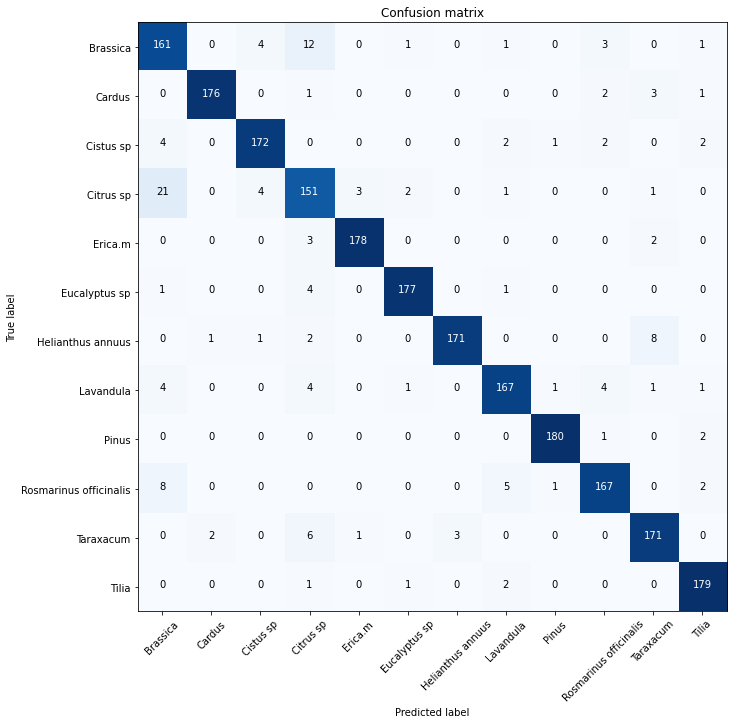

In [26]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
score = metrics.accuracy_score(true_categories_argmax, predicted_categories)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(true_categories_argmax, predicted_categories)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=class_names)
plt.savefig(modelName + '_confusion_matrix_finetune.jpg', bbox_inches='tight')

## Helper function for printing metric and display.

In [30]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_categories_argmax, predicted_categories)

def printMetrics(true_categories_argmax, predicted_categories, y_probs):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(true_categories_argmax, predicted_categories)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(true_categories_argmax, predicted_categories, average='macro')
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(true_categories_argmax, predicted_categories, average='macro')
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    #f1 = f1_score(true_categories_argmax, predicted_categories)
    f1 = f1_score(true_categories_argmax, predicted_categories, average='macro')
    print('F1 score: %f' % f1)

    # kappa
    kappa = cohen_kappa_score(true_categories_argmax, predicted_categories)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(true_categories_argmax, y_probs, multi_class='ovr')
    print('ROC AUC: %f' % auc)
    return accuracy, precision, recall, f1, kappa, auc

# confusion matrix
matrix = confusion_matrix(true_categories_argmax, predicted_categories)
print(matrix)

[[161   0   4  12   0   1   0   1   0   3   0   1]
 [  0 176   0   1   0   0   0   0   0   2   3   1]
 [  4   0 172   0   0   0   0   2   1   2   0   2]
 [ 21   0   4 151   3   2   0   1   0   0   1   0]
 [  0   0   0   3 178   0   0   0   0   0   2   0]
 [  1   0   0   4   0 177   0   1   0   0   0   0]
 [  0   1   1   2   0   0 171   0   0   0   8   0]
 [  4   0   0   4   0   1   0 167   1   4   1   1]
 [  0   0   0   0   0   0   0   0 180   1   0   2]
 [  8   0   0   0   0   0   0   5   1 167   0   2]
 [  0   2   0   6   1   0   3   0   0   0 171   0]
 [  0   0   0   1   0   1   0   2   0   0   0 179]]


# Performance metrics.

In [39]:
acc, prec, rec, f1, kap, auc = printMetrics(true_categories_argmax, predicted_categories, y_pred_ft)
metrics_dict = {"Accuracy":[acc],"Precision":[prec],"Recal":[rec], "F1 score":[f1], "Cohen's Kappa":[kap], "ROC AUC": [auc]}
df_metrics = pd.DataFrame(metrics_dict)

df_metrics

Accuracy: 0.933515
Precision: 0.934794
Recall: 0.933515
F1 score: 0.933928
Cohens kappa: 0.927471
ROC AUC: 0.997358


,Accuracy,Precision,Recal,F1 score,Cohen's Kappa,ROC AUC
0,0.933515,0.934794,0.933515,0.933928,0.927471,0.997358


In [41]:
from sklearn.metrics import classification_report
#metrics_report = classification_report(y_true_num, y_preds, target_names=class_names, digits=3, output_dict=False)
metrics_report = classification_report(true_categories_argmax, predicted_categories, target_names=class_names, digits=3, output_dict=False)
print(metrics_report)

                        precision    recall  f1-score   support

              Brassica      0.809     0.880     0.843       183
                Cardus      0.983     0.962     0.972       183
             Cistus sp      0.950     0.940     0.945       183
             Citrus sp      0.821     0.825     0.823       183
               Erica.m      0.978     0.973     0.975       183
         Eucalyptus sp      0.973     0.967     0.970       183
     Helianthus annuus      0.983     0.934     0.958       183
             Lavandula      0.933     0.913     0.923       183
                 Pinus      0.984     0.984     0.984       183
Rosmarinus officinalis      0.933     0.913     0.923       183
             Taraxacum      0.919     0.934     0.927       183
                 Tilia      0.952     0.978     0.965       183

              accuracy                          0.934      2196
             macro avg      0.935     0.934     0.934      2196
          weighted avg      0.935     